# Modeling interest rate swaps

In [1]:
import QuantLib as ql 
import pandas as pd 
import datetime as dt 
import matplotlib.pyplot as plt 

plt.style.use('bmh')

**Example**<br>
plain vanilla USD swap with 
* 10 million notional 
* 10 year maturity. 
* fixed leg pay 2.5% coupon semiannually
* floating leg pay Libor 3m quarterly.

In [2]:
# set evaluation date

eval_date = ql.Date(1, ql.March, 2022)
ql.Settings.instance().evaluationDate = eval_date

In [3]:
# construct flat yield curve

risk_free_rate = 0.01
libor_rate = 0.02
day_count= ql.Actual365Fixed()

discount_curve = ql.YieldTermStructureHandle(ql.FlatForward(eval_date,
                                                            risk_free_rate,
                                                            day_count))

libor_curve = ql.YieldTermStructureHandle(ql.FlatForward(eval_date,
                                                         libor_rate,
                                                         day_count))

libor3M_index = ql.USDLibor(ql.Period(3, ql.Months), libor_curve)

In [4]:
# construct fixed and floating rate schedule

calendar = ql.UnitedStates()
settle_date = calendar.advance(eval_date, 5, ql.Days)
maturity_date = calendar.advance(settle_date, 10, ql.Years)

fixed_leg_tenor = ql.Period(6, ql.Months)
fixed_schedule = ql.Schedule(settle_date,
                             maturity_date,
                             fixed_leg_tenor,
                             calendar,
                             ql.ModifiedFollowing,
                             ql.ModifiedFollowing,
                             ql.DateGeneration.Forward,
                             False)

float_leg_tenor = ql.Period(3, ql.Months)
float_schedule = ql.Schedule(settle_date,
                             maturity_date,
                             float_leg_tenor,
                             calendar,
                             ql.ModifiedFollowing,
                             ql.ModifiedFollowing,
                             ql.DateGeneration.Forward,
                             False)

In [5]:
# construct vanilla swap

notional = 10**7

fixed_rate = 0.025
fixed_leg_daycount = ql.Actual360()

float_spread = 0.004
float_leg_daycount = ql.Actual360()

interest_rate_swap = ql.VanillaSwap(ql.VanillaSwap.Payer,
                                    notional,
                                    fixed_schedule,
                                    fixed_rate,
                                    fixed_leg_daycount,
                                    float_schedule,
                                    libor3M_index,
                                    float_spread,
                                    float_leg_daycount) 

In [6]:
swap_engine = ql.DiscountingSwapEngine(discount_curve)
interest_rate_swap.setPricingEngine(swap_engine)

In [7]:
def convert_date(d):
    return dt.date(d.year(), d.month(), d.dayOfMonth())

In [8]:
# get fixed leg cash flow

fixed_leg_cash_flow = [(cf.date(), cf.amount()) for cf in interest_rate_swap.leg(0)]
fixed_leg_df = pd.DataFrame(fixed_leg_cash_flow, columns=['Date', 'CashFlow'])
fixed_leg_df.Date = fixed_leg_df.Date.apply(convert_date)
fixed_leg_df.set_index('Date', inplace=True)
fixed_leg_df.head(10)

,CashFlow
Date,
2022-09-08,127777.777778
2023-03-08,125694.444444
2023-09-08,127777.777778
2024-03-08,126388.888889
2024-09-09,128472.222222
2025-03-10,126388.888889
2025-09-08,126388.888889
2026-03-09,126388.888889
2026-09-08,127083.333333


In [9]:
# get floating leg cash flows

float_leg_cash_flow = [(cf.date(), cf.amount()) for cf in interest_rate_swap.leg(1)]
float_leg_df = pd.DataFrame(float_leg_cash_flow, columns=['Date', 'CashFlow'])
float_leg_df.Date = float_leg_df.Date.apply(convert_date)
float_leg_df.set_index('Date', inplace=True)
float_leg_df.head(10)

,CashFlow
Date,
2022-06-08,60760.458147
2022-09-08,60760.458147
2022-12-08,60098.647700
2023-03-08,59436.867427
2023-06-08,60760.458147
2023-09-08,60760.458147
2023-12-08,60098.647700
2024-03-08,60098.647700
2024-06-10,62084.169572


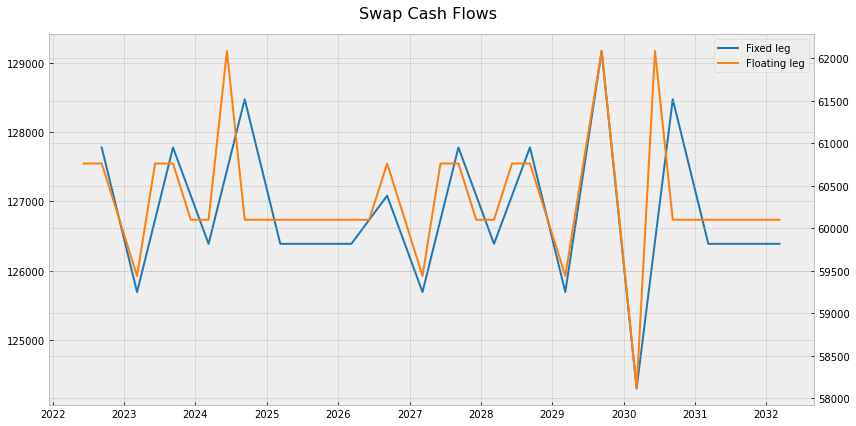

In [10]:
fig, ax = plt.subplots(figsize=(12,6))

line1, = ax.plot(fixed_leg_df, color='tab:blue', label='Fixed leg')

ax2 = ax.twinx()
line2, = ax2.plot(float_leg_df, color='tab:orange', label='Floating leg')

fig.suptitle('Swap Cash Flows', fontsize=16)
plt.legend(handles=[line1, line2])
plt.tight_layout()
plt.show()

In [11]:
analytics = {'Net Present Value': interest_rate_swap.NPV(),
             'Fair Spread': interest_rate_swap.fairSpread(),
             'Fair Rate': interest_rate_swap.fairRate(),
             'Fixed Leg BPS': interest_rate_swap.fixedLegBPS(),
             'Floating Leg BPS': interest_rate_swap.floatingLegBPS()}

In [12]:
analytics

{'Net Present Value': -115053.59184952686,
 'Fair Spread': 0.005193249191164825,
 'Fair Rate': 0.02380525607337559,
 'Fixed Leg BPS': -9629.979218609238,
 'Floating Leg BPS': 9642.0423077944}

In [13]:
for k, v in analytics.items():
    print("{:20s}: {:12.3f}".format(k,v))

Net Present Value   :  -115053.592
Fair Spread         :        0.005
Fair Rate           :        0.024
Fixed Leg BPS       :    -9629.979
Floating Leg BPS    :     9642.042
